### Problem Statement

Task is to look at 60 DNA sequence elements (called "nucleotides" or "base-pairs") and decide if this is a
	a) "intron -> exon" boundary (ie) [These are sometimes called "donors"]
	b) "exon -> intron" boundary (ei) [These are sometimes called "acceptors"]
	c) neither      
 
 Data Source is here:
 https://archive.ics.uci.edu/ml/datasets/Molecular+Biology+%28Splice-junction+Gene+Sequences%29

In [10]:
# -*- coding: utf-8 -*-


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import re


dataset = pd.read_csv('data.csv')


#Take a look at the data 
dataset.describe()

#3178 Unique donors and 3092 unique sequences


,Class,Donor,Sequence
count,3190,3190,3190
unique,3,3178,3092
top,N,HUMMYLCA-ACCEPTOR-924,GTGGAGCAGCTGACCCAGGAGTTCTGTGAGGTAAG...
freq,1655,2,3


### Plot frequency distribution of characters in genome sequence

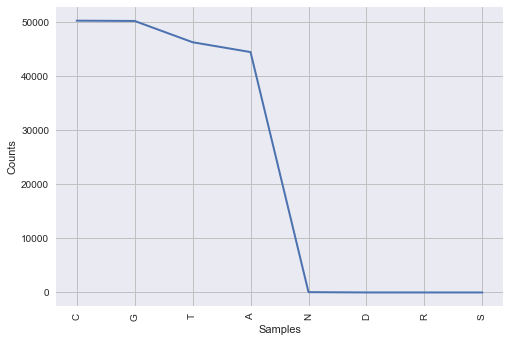

In [11]:
from nltk.probability import FreqDist
genome_list = re.sub("\s+","",dataset['Sequence'].str.cat())
dist = FreqDist(genome_list)
dist.plot()

In [16]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

#Create target variable with encoded class
y = pd.DataFrame(dataset['Class'])
lbl = LabelEncoder()
y= lbl.fit_transform(np.array(y))

C:\Users\takalyan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Feature engineering 

We will add features based on the letter frequency in the DNA sequence. It is essentially a frequency distribution of characters in the 60 element gene sequence.

We will also convert the character to unicode to preserve uniquness of each character.

In [12]:
#Function to calculate letter frequency in a word
def letterCount(word):
    return {c: word.count(c) for c in word}


X = pd.DataFrame()

#Loop throgh all rows
#  - Convert char to unicode
#  - Calculate letter frequencies to create new features
for i in range (0,dataset.shape[0]):
    
    #Extract sequence
    seq = dataset.loc[i,'Sequence']
    
    #Remove whitespace
    seq = re.sub("\s+","", seq)
    
    #Conver char to unicode
    for j in range (0,len(seq)):
        X.loc[i,j] = ord(seq[j])
    
    #Count frequency of alphabets
    cnt = letterCount(seq)
    #Feature Engineering
    for key in (cnt):
        X.loc[i,key] = cnt[key]
    
#Replace missing values of frequency counts with 0
#This step is not essential for Decision Tree based models like XGB
X.fillna(0, inplace=True)

In [13]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,58,59,T,A,G,C,N,D,R,S
count,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,...,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000
mean,71.549843,71.547022,71.663636,71.535737,71.689342,71.647022,71.585266,71.636677,71.642320,72.004075,...,71.524138,71.636677,14.516614,13.945768,15.750784,15.768025,0.017555,0.000627,0.000313,0.000313
std,7.157406,7.278203,7.233335,7.242072,7.454369,7.232564,7.318073,7.405174,7.355142,7.529704,...,7.275169,7.097447,5.241326,5.008604,5.482687,5.707964,0.731630,0.025035,0.017705,0.017705
min,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,...,65.000000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67.000000,67.000000,67.000000,67.000000,65.000000,67.000000,67.000000,67.000000,67.000000,67.000000,...,67.000000,67.000000,11.000000,10.000000,12.000000,12.000000,0.000000,0.000000,0.000000,0.000000
50%,71.000000,67.000000,71.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,71.000000,...,67.000000,71.000000,14.000000,13.000000,15.000000,15.000000,0.000000,0.000000,0.000000,0.000000
75%,71.000000,71.000000,71.000000,71.000000,84.000000,71.000000,71.000000,71.000000,71.000000,84.000000,...,71.000000,71.000000,18.000000,17.000000,19.000000,20.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,...,84.000000,84.000000,44.000000,44.000000,37.000000,40.000000,41.000000,1.000000,1.000000,1.000000


## Model build 

We will use a gradient boosted decision tree model - XGBoost with cross validation to prevent overfitting. 
Test size will be 20% of dataset.




In [17]:


#Build the model
from sklearn.model_selection import KFold,cross_val_score
import xgboost as xgb


#Define model
model = xgb.XGBClassifier(max_depth= 10,   min_child_weight= 3,\
                         subsample= 0.5, \
                         objective= 'multi:softprob', silent= 1)


#Split into train and test set
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=45)

#Train the model
model.fit(X_train,y_train,eval_metric='merror')

#Check against test sample
seed = 5
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
scores = cross_val_score(model, X_test, y_test, cv=kfold)

print ("Average Accuracy = ",np.mean(scores))



Average Accuracy =  0.946701388889


##### Results

Achieved a model accuracy of 95% This can be further optimized by using grid search for parameter tuning but it is outside the scope of this exercise. 